# Official Results for 'Discovering Foodborne Illness in Online Restaurant Reviews' in JAMIA, 2017

This notebook presents the official evaluation of classifiers presented in the paper.

Because of licensing restrictions, we cannot publish the data used in the experiments.

However, the final trained models may be found in the `best_models` directory for inspection and further experimentation.

Additionally, those models are all retrained on the full training data within this notebook with a fixed random seed so that the final numbers could be reproduced if needed.

For inqueries about the results, models, or data, please contact [Tom Effland](mailto:teffland@cs.columbia.edu).

## Table of Contents

1. [Derivations of Selection Bias Corrections](#Selection-Bias-Correction)
    1. [Training](#Training:-Error-Rate)
    2. [Testing](#)
    
2. [Setup](#)
    1. [Data Ingestion](#) (Data is cleaned ahead of time)
    4. [Loading Models](#) (Model hyperparams are pre-tuned)
3. [Sick Task](#)
    1. [Logistic Regression](#)
    2. [Random Forest](#)
    3. [SVM](#)
    4. [Prototype](#)
4. [Multiple Task](#)
    1. [Logistic Regression](#)
    2. [Random Forest](#)
    3. [SVM](#)
    4. [Pipelined Logistic Regression](#)
    5. [Prototype](#)

# Selection Bias Correction

Let $T(x)$ be the biased selection process for labelling data at DOHMH. We treat it as a black-box and model it atomically.

Let $U$ be the set of all Yelp Reviews that have been processed by the system.

Let $B \subset U$ s.t. $B = \{(x,y) | T(x) = 1\}$. $B$ is the biased training set.

Let $B^c \subseteq U \setminus B = \{(x,y) | T(x) = 0\}$. $B^c$ is the biased complement training set.

## Training: Error Rate

We can model the error rate of some classifier $f$ as:

$p(f(x) \ne y) = p(f(x) \ne y | T(x) = 1)p(T(x) = 1) + p(f(x) \ne y | T(x) = 0)p(T(x) = 0)$

and use plugin estimates:

$\hat{p}(T(x) = 1) = \frac{|B|}{|U|}$ (the % of labeled points)

$\hat{p}(f(x) \neq y | T(x)=1) = \frac{1}{|B|}\Sigma_{(x,y) \in B}{I[f(x) \neq y]}$

likewise,

$\hat{p}(f(x) \neq y | T(x)=0) = \frac{1}{|B^c|}\Sigma_{(x,y) \in B^c}{I[f(x) \neq y]}$

therefore

$\hat{p}(f(x) \neq y) = w_B\Sigma_{(x,y) \in B}{I[f(x) \neq y]} + w_{B^c}\Sigma_{(x,y) \in B^c}{I[f(x) \neq y]}$

where 

$w_B = \frac{1}{|U|}$ and $w_{B^c} = (1 - \frac{|B|}{|U|})(\frac{1}{|B^c|})$

Note that when $B^c$ is the entire complement of $B$, then $w_{B^c}$ reduces to $\frac{1}{|U|}$

So, if we are trying to minimize the classification error in the objective function then these are the sample weights to be used when calculating the error

## Testing

We will evaluate models using the F1 score and AUPR metric, calculated empirically on the dev and test sets.

We can bias-correct these the same way, using bias corrections for the precision and recall. Consider the probabilistic form of precision for some classifier $f$:

#### Precision

Let $U$ be the test set.

$Precision = p(y=1|f(x)=1) = \Sigma_{t}{p(y=1 | f(x)=1, T(x) = t)p(T(x)=t|f(x)=1)}$

Let $U_P \subset U$ be the set $\{(x,y) | f(x) = 1\}$. 

**Note** that $U_P$ varies with the classification threshold.

Then as with the error rate, we can find plugin estimates for the necessary quanities.

$\hat{p}(T(x) = 1|f(x)=1) = \frac{1}{|U_P|} \Sigma_{(x,y) \in B}{I[f(x)=1]} = \frac{|B \cap U_P|}{|U_P|}$

and so $\hat{p}(T(x) = 0|f(x)=1) = 1 - \frac{|B \cap U_P|}{|U_P|}$

Also,

$\hat{p}(y=1|f(x)=1, T(x)=1) = \frac{1}{|U_P|} \Sigma_{(x,y) \in B\cap U_P}{I[y=1]} 
 $

and $\hat{p}(y=1|f(x)=1, T(x)=0) = \frac{1}{|U_P|} \Sigma_{(x,y) \in B^c\cap U_P}{I[y=1]}$

Therefore

$Precision = \frac{|B \cap U_P|}{|U_P|} \frac{1}{|U_P|} \Sigma_{(x,y) \in B\cap U_P}{I[y=1]} 
+ (1 - \frac{|B \cap U_P|}{|U_P|})\frac{1}{|U_P|} \Sigma_{(x,y) \in B^c\cap U_P}{I[y=1]}$

#### Recall

The derivation for improtance-weighted (IW) recall follows similary to IW precision.

$Recall = p(f(x)=1|y=1) = \Sigma_{t}{p(f(x)=1| y=1, T(x) = t)p(T(x)=t|y=1)}$

Let $U_R \subset U$ be the set $\{(x,y) | y = 1\}$. 

**Note** that $U_R$ **does not** vary with the classification threshold.

The plugin estimates are:

$\hat{p}(T(x) = 1|y=1) = \frac{1}{|U_R|} \Sigma_{(x,y) \in B}{I[y=1]} = \frac{|B \cap U_R|}{|U_R|}$

and so $\hat{p}(T(x) = 0|y=1) = 1 - \frac{|B \cap U_R|}{|U_R|}$

Also,

$\hat{p}(f(x)=1 |y=1, T(x)=1) = \frac{1}{|U_R|} \Sigma_{(x,y) \in B\cap U_R}{I[f(x)=1]}$

and $\hat{p}(f(x)=1|y=1, T(x)=0) = \frac{1}{|U_R|} \Sigma_{(x,y) \in B^c\cap U_R}{I[f(x)=1]}$

plugging in we have

$ Recall =  \frac{|B \cap U_R|}{|U_R|} \frac{1}{|U_R|} \Sigma_{(x,y) \in B\cap U_R}{I[f(x)=1]}
+ (1 - \frac{|B \cap U_R|}{|U_R|}) \frac{1}{|U_R|} \Sigma_{(x,y) \in B^c\cap U_R}{I[f(x)=1]}$

#### AUPR Curve

Finally, using the above plugin estimates, we can balance data from both $B$ and (a sample from) $B^c$.  We can obtain a series of ordered Precision-Recall points $E = \{(p,r,t)_i | r_i \leq r_{i'}\}$ by varying the classification threshold $t \in [0,1]$ and then using trapezoidal integration to approximate the area under the Recall vs. Precision curve.

#### Bootstrap

For the final evaluation, we would like confidence intervals about the F1 and AUPR. We find these by using the percentile bootstrap:

We calculate bootstrap statistics for the IW-Precision, IW-Recall, and IW-AUPR as follows:

First we calculate the statistic $\bar{x}$ (for each of IW-Precision, IW-Recall, and IW-AUPR).

Then we resample the test dataset with replacement $B$ times and obtain the bootstrap statisic estimates for each set.

Call these $x_1, ...,  x_B$.

Then we can compute confidence intervals around $\bar{x}$ the usual way by finding the $\alpha=.025$ boundary quantiles $\delta_{\alpha}, \delta_{1-\alpha}$, such that 

$$P(\bar{x}^* - \delta_{1-\alpha} \leq \bar{x} \leq \bar{x}^* - \delta_{\alpha}) = .95$$

# Setup

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import time
%matplotlib inline
from copy import deepcopy
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter('ignore')

In [8]:
from experiments.baseline_experiment_util import *

In [9]:
random_seed = 0

## Data Ingestion

In [10]:
biased_data = setup_baseline_data(dataset='twitter', data_path='./data/twitter_data/',
                                  train_regime='biased', test_regime='biased', random_seed=random_seed)
silver_data = setup_baseline_data(dataset='twitter', data_path='./data/twitter_data/',
                                  train_regime='silver', test_regime='silver', random_seed=random_seed)

In [11]:
# train setup
biased_text = np.array(biased_data['train_data']['text'])
biased_sick = np.array(biased_data['train_data']['is_foodborne'])
biased_mult = np.array(biased_data['train_data']['is_multiple'])
biased_weights = calc_train_importance_weights(biased_data['train_data']['is_biased'], biased_data['U'])

# gold_text = np.array(gold_data['train_data']['text'])
# gold_sick = np.array(gold_data['train_data']['is_foodborne'])
# gold_mult = np.array(gold_data['train_data']['is_multiple'])
# gold_weights = calc_train_importance_weights(gold_data['train_data']['is_biased'], gold_data['U'])

silver_text = np.array(silver_data['train_data']['text'])
silver_sick = np.array(silver_data['train_data']['is_foodborne'])
silver_mult = np.array(silver_data['train_data']['is_multiple'])
silver_weights = calc_train_importance_weights(silver_data['train_data']['is_biased'], silver_data['U'])

# test setup
test_data = silver_data['test_data']
B = 1000 # number of bootstrap test set resamples
all_results = {}

## Loading Models

In [12]:
from experiments.lr_model import model as lr_model
from experiments.rf_model import model as rf_model
from experiments.svm_model import model as svm_model
from sklearn.externals import joblib

In [13]:
# logistic regression sick models
best_sick_lr_biased = joblib.load('data/best_models_twitter/best_lr_sick_biased.pkl')
best_sick_lr_silver = joblib.load('data/best_models_twitter/best_lr_sick_silver.pkl')

In [14]:
# random forest sick models
best_sick_rf_biased = joblib.load('data/best_models_twitter/best_rf_sick_biased.pkl')
best_sick_rf_silver = joblib.load('data/best_models_twitter/best_rf_sick_silver.pkl')

In [15]:
# svm sick models
best_sick_svm_biased = joblib.load('data/best_models_twitter/best_svm_sick_biased.pkl')
# best_sick_svm_silver = joblib.load('data/best_models_twitter/best_svm_sick_silver.pkl')

## Sick Task

Here are the notable stats for testing on the Sick task:
* All the test data is from 1/1/2017 and later
* It's about 2/3 biased and 1/3 nonbiased (1975 and 1000 reviews, respectively)
* All 1000 nonbiased reviews are have `No` labels
* The 1975 biased reviews are about 52% `Yes`/`No` (1026/949)

### Logistic Regression

In [16]:
best_sick_lr_biased.fit(biased_text, biased_sick, logreg__sample_weight=biased_weights)
best_sick_lr_silver.fit(silver_text, silver_sick, logreg__sample_weight=silver_weights)
print


B: 999/1000                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

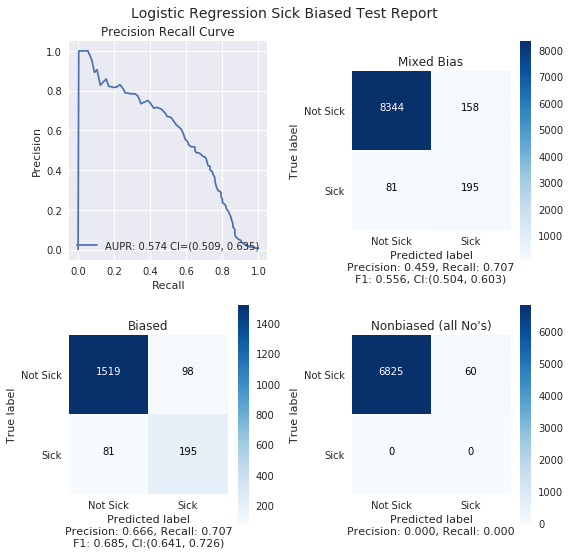

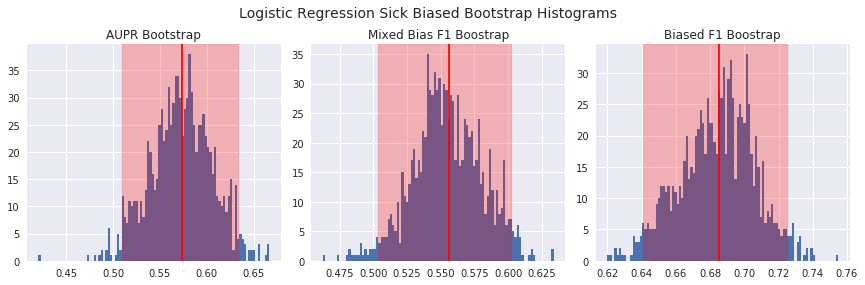

In [17]:
start = time.time()
title = 'Logistic Regression Sick Biased'
all_results[title] = model_report(best_sick_lr_biased, title, 'is_foodborne',
                                  test_data=test_data,
                                  save_fname='figures/sick_lr_biased',
                                  B=B, random_seed=random_seed)
print '\n{} seconds for evaluation'.format(int(time.time()-start))


B: 999/1000                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

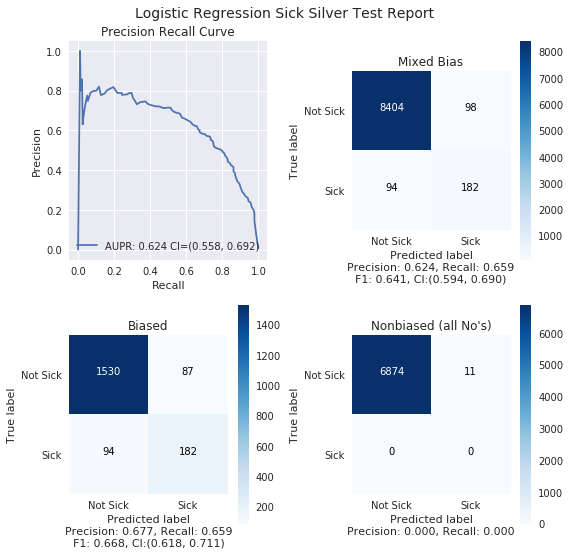

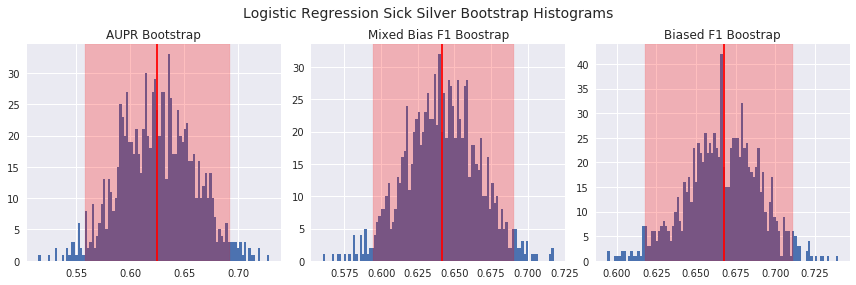

In [18]:
start = time.time()
title = 'Logistic Regression Sick Silver'
all_results[title] = model_report(best_sick_lr_silver, title, 'is_foodborne', 
                                  test_data=test_data,
                                  save_fname='figures/sick_lr_silver',
                                  B=B, random_seed=random_seed)
print '\n{} seconds'.format(int(time.time()-start))

### Precision Recall Tradeoffs

We'd like to explore how we lose precision with the LR models, as we gain recall. This can be visualized by looking at the high recall region of the PR curves. 

In the curve we can see that all of the model precision begins to drop around a recall of .8 start to significantly drop precision around a recall of .9

(<matplotlib.figure.Figure at 0x7f9edd1d7d10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9edc428190>)

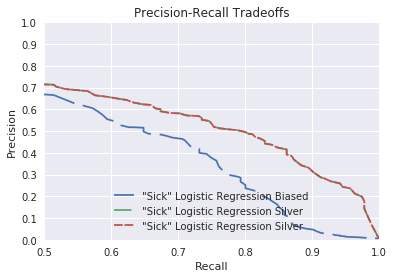

In [19]:
pr_curves([best_sick_lr_biased, best_sick_lr_silver, best_sick_lr_silver], 
          ['"Sick" Logistic Regression Biased', 
           '"Sick" Logistic Regression Silver', 
           '"Sick" Logistic Regression Silver'], 
          'Precision-Recall Tradeoffs', 'is_foodborne', 
          dashes=[[20,5], [10,3], [5,1]],
          test_data=test_data, save_fname='paper_sick_lr',
          figsize=(6,4),
          xlim=(.5,1.),
          yticks=.1*np.arange(11))

In [20]:
print_model_hyperparams(best_sick_lr_biased, 'Logistic Regression Sick Biased')
print
print_model_hyperparams(best_sick_lr_silver, 'Logistic Regression Sick Silver')
print

*** Logistic Regression Sick Biased Hyperparameters ***
{'count__analyzer': u'word',
 'count__binary': False,
 'count__decode_error': u'strict',
 'count__dtype': <type 'numpy.int64'>,
 'count__encoding': u'utf-8',
 'count__input': u'content',
 'count__lowercase': True,
 'count__max_df': 0.89871217241479107,
 'count__max_features': None,
 'count__min_df': 1,
 'count__ngram_range': (1, 3),
 'count__preprocessor': None,
 'count__stop_words': None,
 'count__strip_accents': None,
 'count__token_pattern': u'(?u)\\b\\w\\w+\\b',
 'count__tokenizer': None,
 'count__vocabulary': None,
 'logreg__C': 0.18307382802953678,
 'logreg__class_weight': None,
 'logreg__dual': False,
 'logreg__fit_intercept': True,
 'logreg__intercept_scaling': 1,
 'logreg__max_iter': 100,
 'logreg__multi_class': 'ovr',
 'logreg__n_jobs': 1,
 'logreg__penalty': 'l2',
 'logreg__random_state': None,
 'logreg__solver': 'liblinear',
 'logreg__tol': 0.0001,
 'logreg__verbose': 0,
 'logreg__warm_start': False,
 'tfidf__norm': No

### Random Forest

In [21]:
best_sick_rf_biased.fit(biased_text, biased_sick, rf__sample_weight=biased_weights)
best_sick_rf_silver.fit(silver_text, silver_sick, rf__sample_weight=silver_weights)
print


B: 999/1000                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

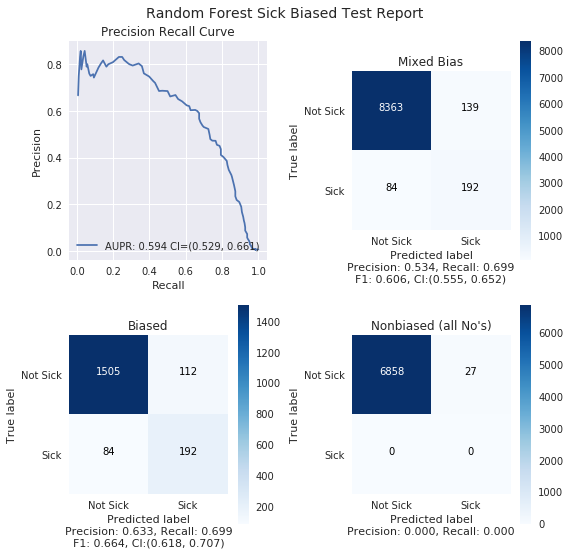

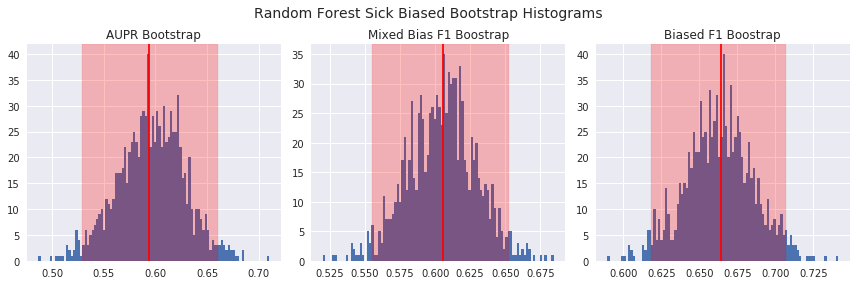

In [22]:
start = time.time()
title = 'Random Forest Sick Biased'
all_results[title] = model_report(best_sick_rf_biased, title, 'is_foodborne',
                                  save_fname='figures/sick_rf_biased',
                                  test_data=test_data,
                                  B=B, random_seed=random_seed)
print '\n{} seconds'.format(int(time.time()-start))


B: 999/1000                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

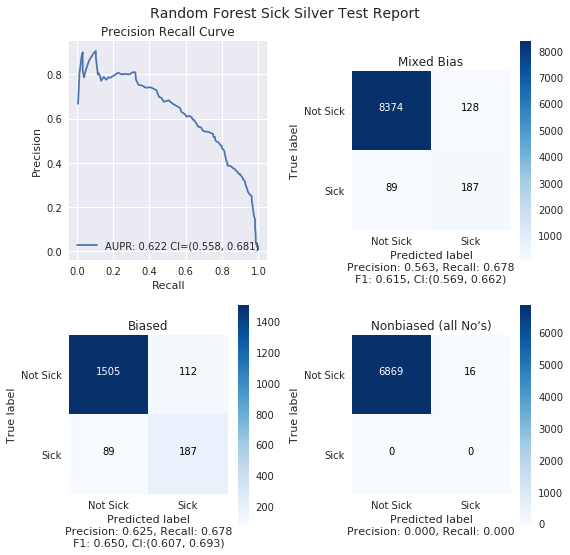

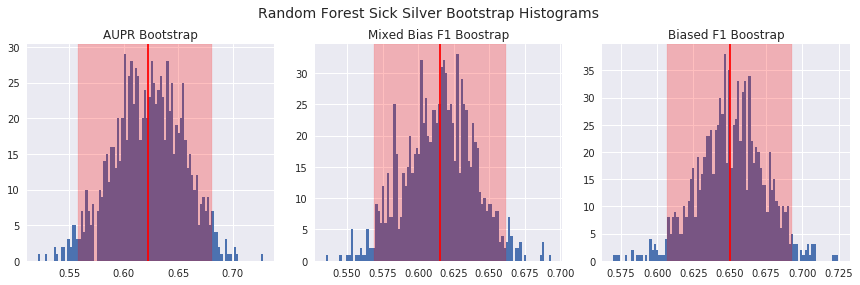

In [23]:
start = time.time()
title = 'Random Forest Sick Silver'
all_results[title] = model_report(best_sick_rf_silver, title, 'is_foodborne',
                                  save_fname='figures/sick_rf_silver',
                                  test_data=test_data,
                                  B=B, random_seed=random_seed)
print '\n{} seconds'.format(int(time.time()-start))

In [24]:
print_model_hyperparams(best_sick_rf_biased, 'Random Forest Sick Biased')
print
print_model_hyperparams(best_sick_rf_silver, 'Random Forest Sick Silver')
print

*** Random Forest Sick Biased Hyperparameters ***
{'count__analyzer': u'word',
 'count__binary': False,
 'count__decode_error': u'strict',
 'count__dtype': <type 'numpy.int64'>,
 'count__encoding': u'utf-8',
 'count__input': u'content',
 'count__lowercase': True,
 'count__max_df': 0.77767276498823101,
 'count__max_features': 1000,
 'count__min_df': 1,
 'count__ngram_range': (1, 2),
 'count__preprocessor': None,
 'count__stop_words': None,
 'count__strip_accents': None,
 'count__token_pattern': u'(?u)\\b\\w\\w+\\b',
 'count__tokenizer': None,
 'count__vocabulary': None,
 'rf__bootstrap': True,
 'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features': 'log2',
 'rf__max_leaf_nodes': None,
 'rf__min_impurity_split': 1e-07,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__min_weight_fraction_leaf': 0.0,
 'rf__n_estimators': 178,
 'rf__n_jobs': 1,
 'rf__oob_score': True,
 'rf__random_state': 0,
 'rf__verbose': 0,
 'rf__warm_start': False,

### SVM

In [30]:
best_sick_svm_biased.fit(biased_text, biased_sick, svc__sample_weight=biased_weights)
# best_sick_svm_silver.fit(silver_text, silver_sick, svc__sample_weight=silver_weights)
print


B: 999/1000                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

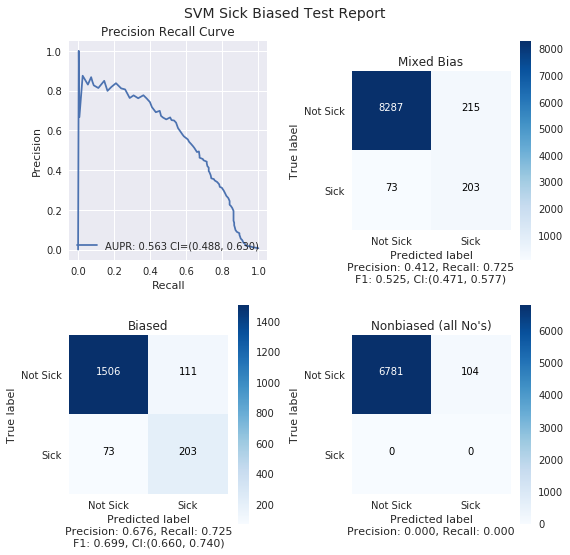

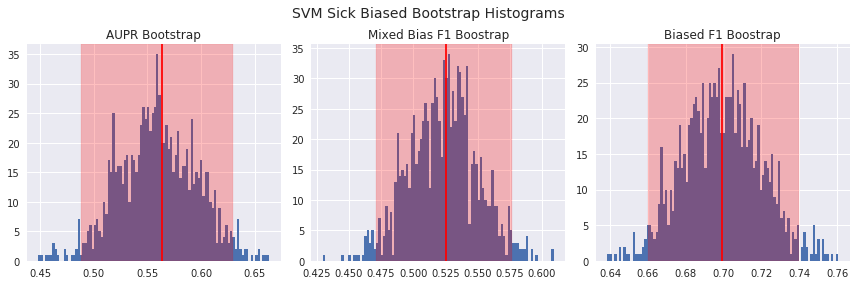

In [26]:
start = time.time()
title = 'SVM Sick Biased'
all_results[title] = model_report(best_sick_svm_biased, title, 'is_foodborne',
                                  save_fname='figures/sick_svm_biased',
                                  test_data=test_data,
                                  B=B, random_seed=random_seed)
print '\n{} seconds'.format(int(time.time()-start))

In [27]:
# start = time.time()
# title = 'SVM Sick Gold'
# all_results[title] = model_report(best_sick_svm_gold, title, 'is_foodborne',
#                                   save_fname='figures/sick_svm_gold',
#                                   test_data=test_data,
#                                   B=B, random_seed=random_seed)
# print '\n{} seconds'.format(int(time.time()-start))

In [31]:
# start = time.time()
# title = 'SVM Sick Silver'
# all_results[title] = model_report(best_sick_svm_silver, title, 'is_foodborne',
#                                   save_fname='figures/sick_svm_silver',
#                                   test_data=test_data,
#                                   B=B, random_seed=random_seed)
# print '\n{} seconds'.format(int(time.time()-start))

In [33]:
print_model_hyperparams(best_sick_svm_biased, 'SVM Sick Biased')
print
# print_model_hyperparams(best_sick_svm_silver, 'SVM Sick Silver')
# print

*** SVM Sick Biased Hyperparameters ***
{'count__analyzer': u'word',
 'count__binary': False,
 'count__decode_error': u'strict',
 'count__dtype': <type 'numpy.int64'>,
 'count__encoding': u'utf-8',
 'count__input': u'content',
 'count__lowercase': True,
 'count__max_df': 0.75894291577334649,
 'count__max_features': None,
 'count__min_df': 1,
 'count__ngram_range': (1, 2),
 'count__preprocessor': None,
 'count__stop_words': None,
 'count__strip_accents': None,
 'count__token_pattern': u'(?u)\\b\\w\\w+\\b',
 'count__tokenizer': None,
 'count__vocabulary': None,
 'svc__C': 0.071069812311930172,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': None,
 'svc__degree': 3,
 'svc__gamma': 'auto',
 'svc__kernel': 'linear',
 'svc__max_iter': -1,
 'svc__probability': True,
 'svc__random_state': None,
 'svc__shrinking': True,
 'svc__tol': 0.001,
 'svc__verbose': False,
 'tfidf__norm': None,
 'tfidf__smooth_idf': True,
 'tfidf__sublinear_tf': F

## Compile the scores into a nice table

In [34]:
sick_table = pd.DataFrame()
# mult_table = pd.DataFrame()
for name, result in sorted(all_results.items(), key=lambda x:x[0]):
    data = {k:v for k,v in result.items() if ('samples' not in k) and ('_ci' not in k) }
    data.update({k+'_b':v[0] for k,v in result.items() if '_ci' in k})
    data.update({k+'_t':v[1] for k,v in result.items() if '_ci' in k})
    data['name'] = name
    if 'Sick' in name:
        sick_table = sick_table.append(data, ignore_index=True)
    else:
        pass
        # mult_table = mult_table.append(data, ignore_index=True)
sick_table.set_index('name', inplace=True)
# mult_table.set_index('name', inplace=True)

In [35]:
print sick_table.columns

Index([u'aupr', u'aupr_ci_b', u'aupr_ci_t', u'biased_f1', u'biased_f1_ci_b',
       u'biased_f1_ci_t', u'biased_precision', u'biased_recall', u'mixed_f1',
       u'mixed_f1_ci_b', u'mixed_f1_ci_t', u'mixed_precision',
       u'mixed_recall'],
      dtype='object')


In [36]:
sick_table.to_csv('sick_results.csv')
sick_table[['mixed_f1', 'mixed_f1_ci_b', 'mixed_f1_ci_t']]

,mixed_f1,mixed_f1_ci_b,mixed_f1_ci_t
name,,,
Logistic Regression Sick Biased,0.556121,0.503575,0.602961
Logistic Regression Sick Silver,0.641466,0.594266,0.690366
Random Forest Sick Biased,0.605595,0.554976,0.652396
Random Forest Sick Silver,0.615277,0.569087,0.662057
SVM Sick Biased,0.525435,0.470988,0.576631


In [37]:
# mult_table.to_csv('mult_results.csv')
# mult_table[['mixed_f1', 'mixed_f1_ci_b', 'mixed_f1_ci_t']]

### Write out the final Sick and Multiple classifiers -- Sick LR Silver and Mult LR Pipelined Silver

In [38]:
joblib.dump(best_sick_lr_silver, 'final_models/final_twitter_sick_model.gz')
# joblib.dump(sick_only_mult_lr_silver, 'final_models/final_yelp_mult_model.gz')

['final_models/final_twitter_sick_model.gz']